# Classification Models

## Table of contents:
* [Maximum Likelihood logistic regression](#maxlike)
* [Bayesian logistic regression](#bayesian)
* [Non-linear logistic regression](#non-linear)
* [Dual logistic regression](#dual)
* [Relevance vector classification](#relevant-vector)
* [Incremental fitting and boosting](#boosting)
* [Classification trees](#trees)
* [Random trees, forests, and ferns](#forest)

# Computing kernels more efficiently with numpy

Regarding computing the kernels, one often has to subtraction and multiplication of huge matrices. Let's say we consider two matrices $X_{1}$ and $X_{2}$

$$\begin{align}
\mathbf{x}_{i} \quad & = &\quad (1, x_{1}, \cdots, x_{D-1})^{T}\\
X1.shape \quad & = &\quad (\mathbf{x}_{1}, \cdots, \mathbf{x}_{N_{1}}) \quad & = &\quad (D, N1)\\
X2.shape \quad & = &\quad (\mathbf{x}_{1}, \cdots, \mathbf{x}_{N_{2}}) \quad & = &\quad (D, N2)
\end{align}$$

and we want to compute the following matrix $\tilde{X}_{12}$ for all the combinations of $i$ and $j$.

$$\begin{align}
\tilde{X}_{12}.shape \quad & = &\quad (N1, N2)\\
[\tilde{X}_{12}]_{i,j} \quad & = &\quad ([X_{1}]_{:,i} - [X_{2}]_{:,j})^{T}([X_{1}]_{:,i} - [X_{2}]_{:,j}) \quad & = &\quad (\mathbf{x}_{i} - \mathbf{x}_{j})^{T}(\mathbf{x}_{1} - \mathbf{x}_{j})
\end{align}$$

In order to efficiently compute this matrix, let us break down the problem.

$$\begin{align}
([X_{1}]_{:,i} - [X_{2}]_{:,j})^{T}([X_{1}]_{:,i} - [X_{2}]_{:,j}) \quad & = &\quad [X_{1}]^{T}_{:,i}[X_{1}]_{:,i} - [X_{2}]^{T}_{:,j}[X_{1}]_{:,i} - [X_{1}]^{T}_{:,i}[X_{2}]_{:,j} + [X_{2}]^{T}_{:,j}[X_{2}]_{:,j} \\
\quad & = &\quad [X_{1}^{T}X_{1}]_{i,i} - [X_{1}^{T}X_{2}]_{i,j} - [X_{2}^{T}X_{1}]_{j,i} +[X_{2}^{T}X_{2}]_{j,j}\\
\quad & = &\quad [X_{1}^{T}X_{1}]_{i,i} - 2 [X_{1}^{T}X_{2}]_{i,j} +[X_{2}^{T}X_{2}]_{j,j}
\end{align}$$

We now notice that we should compute 3 matrices $X_{1}^{T}X_{1}$, $X_{1}^{T}X_{2}$ and $X_{2}^{T}X_{2}$. Furthermore, we should notice that we only need the diagonal elements of $X_{1}^{T}X_{1}$ and $X_{2}^{T}X_{2}$. Hence, we don't have to compute the full matrix. Overall, we need to compute

$$\begin{align}
diag(X_{1}^{T}X_{1})\\
X_{1}^{T}X_{2}\\
diag(X_{2}^{T}X_{2})
\end{align}$$

Obtaining these helps the computation. However, we would like to avoid using double for loops going over $i$ and $j$ and exploit the fast lower level computation of numpy. Hence, we 

$$\begin{align}
diag(X_{1}^{T}X_{1}) \quad & \Rightarrow &\quad  np.tile(diag(X_{1}^{T}X_{1})^T, [1, N2]) \quad & \equiv & \quad diagX_{11}  \quad & : &\quad (N1, N2)\\
X_{1}^{T}X_{2} \quad & \Rightarrow &\quad  X_{1}^{T}X_{2}  \quad &\equiv & \quad X_{12} \quad & : &\quad (N1, N2) \\
diag(X_{2}^{T}X_{2}) \quad & \Rightarrow &\quad  np.tile(diag(X_{2}^{T}X_{2})^T, [N1, 1])  \quad  & \equiv &\quad diagX_{22} \quad & : &\quad (N1, N2)
\end{align}$$

Having these, now it's merely addition/subtractions of them to obtain $\tilde{X}_{12}$.
$$\begin{align}
\tilde{X}_{12} \quad & = &\quad  diagX_{11} - 2X_{12} + diagX_{22} \quad & : &\quad (N1, N2)
\end{align}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [232]:
class DataSet:
    def __init__(self):
        pass
        
    def generate_data_set_dim2_nonlinear(self, ns):
        """
        this function generates a 2d data set of two classes which are linearly separated.

        Arguments:
            ns: number of samples

        Output:
            ds1: data on the negative side (3, ns). ds1[1] = 0 is the label.
            ds2: data on the positive side (3, ns). ds2[1] = 0 is the label.
            data  : data combined ds1 and ds2 and shuffled. (2, ns)
            label : label combined ds1 and ds2 and shuffled. (2, ns)
        """
        ns_neg = int(0.5 * ns)
        ns_pos = ns - ns_neg

        ang1 = np.linspace(0, 2*np.pi, ns_neg)
        rad1 = ang1 + 0.05
        ang1 += 0.4 * np.pi * (np.random.rand(ns_neg) - 0.5)
        ds1x = rad1 * np.cos(ang1)
        ds1y = rad1 * np.sin(ang1)
        ds1 = np.vstack((ds1x, ds1y))

        ang2 = np.linspace(0, 2*np.pi, ns_neg)
        rad2 = ang2 + 0.05
        ang2 += 0.4 * np.pi * (np.random.rand(ns_neg) - 0.5)+ np.pi
        ds2x = rad2 * np.cos(ang2)
        ds2y = rad2 * np.sin(ang2)
        ds2 = np.vstack((ds2x, ds2y))

        ds1s = np.vstack((ds1, np.zeros(ns_neg)))
        ds2s = np.vstack((ds2, np.ones(ns_pos)))
        ds = np.hstack((ds1s, ds2s))
        np.random.shuffle(ds.T)

        data = ds[:2]
        label = ds[2][np.newaxis, :]

        datas, mu, sg = self.scale_coordinates(data)
        ds1s = (ds1[:2] - mu)/sg
        ds2s = (ds2[:2] - mu)/sg

        red  = plt.scatter(ds1s[0], ds1s[1], c=(1., 0., 0.), s=3)
        blue = plt.scatter(ds2s[0], ds2s[1], c=(0., 0., 1.), s=3)
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))
        plt.legend([red, blue], ["group 0", "group 1"])

        ds = {'1': ds1s, '2': ds2s}
        return ds, datas, label

    def scale_coordinates(self, x):
        mu = x.mean(keepdims=1)
        sg = x.std()
        xs = (x - mu)/sg
        return xs, mu, sg



In [233]:
class KernelDualLogisticRegression:
    def __init__(self, x, w):
        self.D = x.shape[0]
        self.N = x.shape[1]
        self.x = x
        self.w = w
        self.psi = np.zeros((self.N, 1))
        self.sig = np.zeros((self.N, 1))
        self.Kxx = np.zeros((self.N, self.N))
        self.cost = 0
        self.mu = np.zeros((self.N, 1))
        self.sgm = np.zeros((self.N, self.N))
        self.lmd = 0
        self.sgps = 100
        assert x.shape[1] == w.shape[1]

    def cost_function(self):
        """
        this function computes logistic cost function

        Arguments:
            psi    :  (N, 1)
            self.x :  (D, N)
        
        Intermediates:
            sig :  (N, 1)

        Output:
            L:     scalar. cost function.
        """
        L  = -np.dot(self.w, np.log(self.sig))
        L += -np.dot(1 - self.w, np.log(1 - self.sig))
        return L

    def sigmoid(self):
        """
        this function computes sigmoid function

        Arguments:
            psi    :  (N, 1)
            self.x :  (D, N)

        Intermediates:
            arg :  (1, N)
         
        Output:
            sig :  (N, 1)
        """
        arg = np.dot(self.psi.T, self.Kxx)
        arg[arg > 200] = 200
        arg[arg < -200] = -200
        sig = 1 / (1 + np.exp(-arg))
        return sig.T
    
    def kernel_rbf(self, x1, x2):
        """
        Arguments:
            x1:    D x N1 
            x2:    D x N2
            alp:   scalar. std of the gaussians.

        Output:
            exp_dlt2:  kernel matrix. N1 x N2

        """
        assert x1.shape[0] == x2.shape[0], 'axis0 of the inputs should be equal'
        if np.array_equal(x1, x2):
            N1 = x1.shape[1]
            x12 = np.dot(x1.T, x1)
            x11 = np.diag(x12)[:, np.newaxis]
            x22 = x11.T
            diagX11 = np.tile(x11, [1, N1])
            diagX22 = np.tile(x22, [N1, 1])
            X12 = diagX11 - 2 * x12 + diagX22
            X12 *= -0.5 / (self.lmd**2)
            exp_X12 = np.exp(X12)
        else:
            N1 = x1.shape[1]
            N2 = x2.shape[1]
            x11 = (x1**2).sum(axis=0, keepdims=1)
            x22 = (x2**2).sum(axis=0, keepdims=1)
            diagX11 = np.tile(x11.T, [1, N2])
            diagX22 = np.tile(x22, [N1, 1])
            x12 = np.dot(x1.T, x2)
            X12 = diagX11 - 2 * x12 + diagX22
            X12 *= -0.5 / (self.lmd**2)
            exp_X12 = np.exp(X12)
        return exp_X12
    
    def set_psi_sig_cost(self, psi):
        """
        this function sets psi and update the sigmoid.

        Arguments:
            psi    :  (N, 1)
        """
        assert psi.shape[0] == self.N
        assert psi.shape[1] == 1
        self.psi = psi
        self.sig = self.sigmoid()
        self.cost = self.cost_function()

    def dL_dtheta(self):
        """
        this function generates dda/dphidalp.

        Arguments:
            self.x :  (D, N)

        Intermediate:
            sig   : (N, 1)
            pre   : (1, N)
            xx    : (N, N)

        Output:
            dLdt  : (N, 1)
        """
        err = self.sig.T - self.w
        dLdt = -(err * self.Kxx).sum(axis=1, keepdims=1)
        return dLdt
    
    def ddL_dtheta_dtheta(self):
        """
        this function generates dda/dphidalp.

        Arguments:
            self.x :  (D, N)

        Intermediate:
            sigder : (1, N)
            sxx    : (N, N)
            xx     : (N, N)

        Output:
            dLdt  : (1, N)
        """
        sigder = self.sig * (1 - self.sig)
        ddLdtdt = np.zeros((self.N, self.N))
        for i in range(self.N):
            ddLdtdt += -sigder[i] * np.outer(self.Kxx[i, :], self.Kxx[i, :])
        return ddLdtdt

    def newton_method_update(self, psi, alpha):
        """
        this function computes sigmoid function

        Arguments:
            alpha:   scalar
            
        Intermediate:
            dLdt : (N, 1)
            hess : (N, N)

        Output:
            psi  :  (N, 1)
        """
        dLdt = self.dL_dtheta() - psi / self.sgps
        hess = self.ddL_dtheta_dtheta()
        self.hess = hess
        hess -= 1 / self.sgps
        hessinv = np.linalg.inv(hess)
        update = alpha * np.dot(hessinv, dLdt)
        psi -= update
        return psi

    def optimization(self, psi, lmd, sgps, beta1=0.9, alpha=0.01, nstep=1000):
        """
        this function computes sigmoid function

        Arguments:
            datab:   (D, ns)  D contains bias as well.
            label:   (1, ns)
            phi  :   (1, D)
            alpha:   scalar

        Output:
            sig  :  (ns, 1)
        """
        self.lmd = lmd
        self.sgps = sgps
        self.Kxx = self.kernel_rbf(self.x, self.x)
        dlt = 1
        step = 0
        costs = np.zeros(nstep)
        self.set_psi_sig_cost(psi)
        costs[step] = self.cost
        vsum = np.zeros((psi.shape))
        while True:
            step += 1
            if step == nstep:
                break
            psi, vsum =  self.momentum(self.psi, alpha, beta1, vsum)
            #psi =  self.vanilla(self.psi, alpha)
            #psi = self.newton_method_update(self.psi, alpha)
            self.set_psi_sig_cost(psi)
            costs[step] = self.cost
            #dlt = np.abs(costs[step] - costs[step - 1])
        strng = '{:d} steps done:'.format(step)
        print(strng)
        self.mu = self.psi
        self.sgm = -np.linalg.inv(self.ddL_dtheta_dtheta())
        return self.psi
    
    def laplace_approximated_inference(self, mu, sgm):
        """
        this function computes sigmoid function

        Arguments:
            mu   : (NN, )
            sgm  : (NN, )

        Output:
            inf  : (NN, )
        """
        assert mu.shape[0] == sgm.shape[0]
        sqt = 1 + np.pi * sgm**2 / 8
        arg = -mu / np.sqrt(sqt)
        denom = 1 + np.exp(arg)
        inf = 1 / denom
        return inf
    
    def plot_decision_boundary_dim2(self):
        """
        this function computes sigmoid function

        Arguments:
            phi  : phi. (1, (K+1))
            alp  : alpha. (D, K)
            beta : scalar. learning rate.
            lmd  : scalar.

        Intermediate:
            dLdt   : ((K+1+KD), 1)
            ddLdtdt: ((K+1+KD), (K+1+KD))

        Output:
            theta: (1, (K+1+KD))
        """
        n = 201
        nn = n**2
        x = np.linspace(-3, 3, n)
        y = np.linspace(-3, 3, n)
        xg, yg = np.meshgrid(x, y)
        xss = xg.reshape(1, nn)
        yss = yg.reshape(1, nn)
        xys = np.vstack((xss, yss))
        Kxxs = self.kernel_rbf(self.x, xys)
        mua = np.dot(self.mu.T, Kxxs)
        sgma = (np.dot(self.sgm * 1e-15, Kxxs) * Kxxs).sum(axis=0, keepdims=1)
        inf = self.laplace_approximated_inference(mua.squeeze(), sgma.squeeze())
        inf = inf.reshape(n, n)
        inf = np.flipud(inf)
        plt.imshow(inf, extent=[-3, 3, -3, 3])

    def vanilla(self, psi, alpha):
        """
        performs vanilla gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt     : (1, K + 1 + K * D)
            theta    : (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            sgps     : std squared of prior. acting as regularization.
            
        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        dLdt  = self.dL_dtheta()
        psi += -alpha * dLdt
        psi += -psi / self.sgps
        return psi
    
    def momentum(self, psi, alpha, beta1, vsum):
        """
        performs momentum gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gs']  : gs. momentum. gradient sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            rate[b1] : scalar. rate for gs. gradient sum.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """ 
        vsum = beta1 * vsum
        dLdt= self.dL_dtheta()
        psi += -alpha * dLdt
        psi += -psi / self.sgps
        return psi, vsum



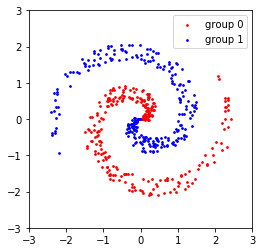

In [244]:
N = 500
plt.rcParams['figure.figsize'] = (4.0, 4.0)
ds, x, w = DataSet().generate_data_set_dim2_nonlinear(N)

100000 steps done:


(-3, 3)

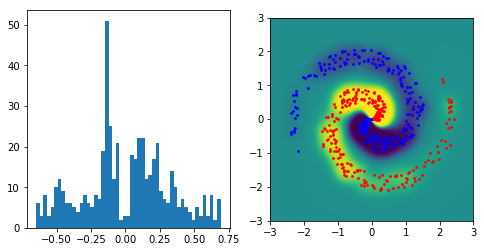

In [246]:
nstep = 100000
alpha = 2e-6
lmd   = 0.2
sgps  = 10000
beta1 = 0.9

psi = 5*(np.random.rand(N, 1)-0.5)

plt.rcParams['figure.figsize'] = (8.0, 4.0)
plt.subplot(1,2,1)
kdlr = KernelDualLogisticRegression(x, w)
psi = kdlr.optimization(psi, lmd, sgps, beta1, alpha, nstep)
_ = plt.hist(psi, bins = 51)

plt.subplot(1,2,2)
kdlr.plot_decision_boundary_dim2()
red  = plt.scatter(ds['1'][0], ds['1'][1], c=(1., 0., 0.), s=3)
blue = plt.scatter(ds['2'][0], ds['2'][1], c=(0., 0., 1.), s=3)
plt.xlim((-3, 3))
plt.ylim((-3, 3))

In [ ]:
def hello(a, b, *args):
    print('a = ', a)
    print('b = ', b)
    print(args)

def hallo():
    a = 2
    b = 3
    c = 4
    d = 5
    hello(a, b, c, d)
    

In [ ]:
a = 4
b = 3
c = 9
d = 23
hallo()

In [ ]:
a = 4
b = 3
c = 9
d = 23
hello(a, b, c, d)

In [ ]:
def outer(a, b):
    def inner(c, d):
        return c + d
    return inner(a, b)

outer(1, 2)

In [143]:
n = 5
a = 1e-8*np.random.rand(n, n)
np.linalg.inv(a)

array([[ -1.78434547e+07,   1.34902020e+08,  -6.07017117e+07,
         -1.84854387e+08,   2.69954894e+05],
       [  1.16046114e+08,  -7.38401064e+07,  -1.10076336e+08,
          1.63725083e+08,   1.80216277e+07],
       [ -1.81641710e+07,   7.73013632e+06,   2.34897189e+08,
          1.13633449e+08,  -2.40218983e+08],
       [ -5.85133095e+07,   6.73242685e+07,  -2.98377624e+08,
          3.95954760e+07,   2.58431852e+08],
       [  3.46048351e+07,  -6.69087457e+07,   1.02481961e+08,
         -2.97668057e+07,   6.11452969e+07]])